In [1]:
# Import packages
import numpy as np
import pandas as pd
from missingno  import matrix

pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 2500
pd.set_option("display.max_columns", None)

In [2]:
path = "../data/raw/ITMO production data.csv"
data = pd.read_csv(path)

rename_dict = {
    "Номер скважины": "cat",
    "datetime": "date",
    "Объем жидкости": "v_fluid",
    "Объем нефти": "v_oil",
    "Дебит нефти": "oil",
    "Дебит газа (ТМ)": "gas",
    "Газовый фактор рабочий (ТМ)": "gor",
    "Дебит газа попутного": "associated_gas",
    "Дебит жидкости (ТМ)": "fluid"
}
data.rename(columns=rename_dict, inplace=True)

data['date'] = pd.to_datetime(data['date'])

data

,date,cat,oil,Давление забойное,x,y,v_fluid,v_oil,Активная мощность (ТМ),Время работы (ТМ),gor,Давление буферное,Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ),gas,associated_gas,fluid,Коэффициент мощности (ТМ)
0,1990-08-01,0,19.939,NaN,18670.86,5714.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-08-02,0,19.939,39.064454,18670.86,5714.86,NaN,NaN,50.851351,9.600833,NaN,NaN,33.913336,39.064454,1.887872,30.293676,3843.746667,24.25,24.250000,98.534314
2,1990-08-03,0,21.172,39.064487,18670.86,5714.86,NaN,NaN,52.353846,NaN,NaN,NaN,33.806090,39.064487,1.885714,30.261774,3900.955000,25.75,25.833333,99.139785
3,1990-08-04,0,22.529,38.965297,18670.86,5714.86,NaN,NaN,51.242424,9.600000,NaN,NaN,33.695717,38.965297,1.875851,30.212768,3874.505000,27.40,27.933333,98.744318
4,1990-08-05,0,22.529,38.766822,18670.86,5714.86,NaN,NaN,50.910256,9.563889,NaN,NaN,33.695717,38.766822,1.873163,30.109119,3853.696667,27.40,27.400000,98.419689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67131,1992-04-07,105,7.646,122.180672,14230.22,22456.04,NaN,NaN,252.298969,24.000000,NaN,NaN,122.180672,99.535735,11.548286,20.536082,NaN,451.36,451.358333,72.876289
67132,1992-04-08,105,7.639,122.182381,14230.22,22456.04,15472.802,161.526,251.647423,24.000000,NaN,NaN,122.182381,99.202518,11.556784,20.459184,NaN,450.97,450.972727,72.855670
67133,1992-04-09,105,7.657,122.183551,14230.22,22456.04,NaN,NaN,251.713542,24.000000,NaN,13.0,122.183551,99.119048,11.583542,20.104167,NaN,452.03,452.027273,72.302083
67134,1992-04-10,105,7.654,122.180372,14230.22,22456.04,NaN,NaN,251.504167,24.000000,NaN,NaN,122.180372,98.744075,11.601396,20.052083,NaN,451.85,451.850000,72.041667


# Coords

In [3]:
df = data[["cat", "x", "y"]].copy()
df = df.drop_duplicates().reset_index(drop=True)

print(df.shape)
df.head()

(106, 3)


,cat,x,y
0,0,18670.86,5714.86
1,1,19964.69,10000.63
2,2,20541.78,9806.47
3,3,12578.90,7805.61
4,4,9828.65,18016.98


In [4]:
path = "../data/interim/itmo_coords.csv"

df.to_csv(path, index=False)

# Monthly data

In [4]:
# Take only monthly data - Volumes of fluid and oil
df = data[["date", "cat", "v_fluid", "v_oil",]]

# Drop Nans and days
df = df[~df["v_fluid"].isna()]# data["v_fluid"] == 0)]#.reset_index(drop=True)[["date", "cat", "v_fluid", "v_oil",]]
df['date'] = df['date'].dt.to_period('M')

# Take max value from repetative
v_df = df.groupby(["cat", "date"]).max().reset_index()

df.head()

,date,cat,v_fluid,v_oil
7,1990-08,0,788.311,757.568
38,1990-09,0,1012.996,925.906
68,1990-10,0,53.333,50.352
99,1990-11,0,685.816,667.085
130,1990-12,0,664.102,645.788


In [6]:
path = "../data/interim/itmo_monthly.csv"

df.to_csv(path, index=False)

# Main Data

In [7]:
df = data[[
    'date', 'cat', 'gor', 'oil', 'gas', 'associated_gas', 'fluid', 
    'Время работы (ТМ)', 'Активная мощность (ТМ)', 'Коэффициент мощности (ТМ)',
    'Давление забойное', 'Давление буферное', 'Давление забойное от Hд', 'Давление забойное от Pпр', 'Давление линейное (ТМ)', 'Давление на входе ЭЦН (ТМ)'
    ]]

df.sample(10)

,date,cat,gor,oil,gas,associated_gas,fluid,Время работы (ТМ),Активная мощность (ТМ),Коэффициент мощности (ТМ),Давление забойное,Давление буферное,Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ)
59732,1991-02-21,94,NaN,7.3910,NaN,99.13,99.128571,24.000000,52.335878,91.412214,52.231324,NaN,52.231324,NaN,14.484519,238.770000
54909,1992-02-09,86,NaN,0.2750,146.225000,0.60,0.600000,NaN,NaN,NaN,146.404994,NaN,80.208779,146.404994,14.357852,105.000000
44220,1991-11-24,69,651.844,15.2210,4274.860000,18.80,18.800000,10.089722,33.961364,76.409091,23.952007,NaN,23.952007,24.329016,4.478545,17.651163
26977,1991-02-20,42,NaN,10.2480,1033.790000,16.20,16.200000,4.938611,57.833333,52.166667,90.036194,NaN,89.034221,90.036194,15.673185,29.780488
46464,1991-04-02,73,NaN,9.1680,5351.766667,42.85,42.850000,13.300000,84.252174,86.807175,29.339011,NaN,30.223382,29.339011,15.824686,20.943722
42087,1991-02-24,66,NaN,14.4220,2949.416000,17.54,17.540000,8.284444,47.583333,90.815789,45.864226,NaN,45.864226,NaN,20.609452,238.770000
47287,1991-10-22,74,NaN,9.6220,NaN,15.13,15.133333,5.327500,56.305405,94.432432,32.749272,NaN,32.749272,32.302392,12.402109,22.872598
15217,1991-10-13,23,NaN,9.9480,NaN,16.15,16.150000,24.000000,26.216667,50.307692,95.854506,NaN,95.854506,NaN,16.703728,12.000000
48245,1991-01-13,76,NaN,2.7155,NaN,NaN,118.114286,24.000000,128.067568,90.013514,46.433056,NaN,46.433056,66.536853,19.966931,44.224865
46873,1990-09-03,74,468.973,15.7370,2285.222500,23.33,23.325000,5.199444,28.000000,41.500000,28.628892,NaN,28.628892,NaN,1.183529,32.770000


<Axes: >

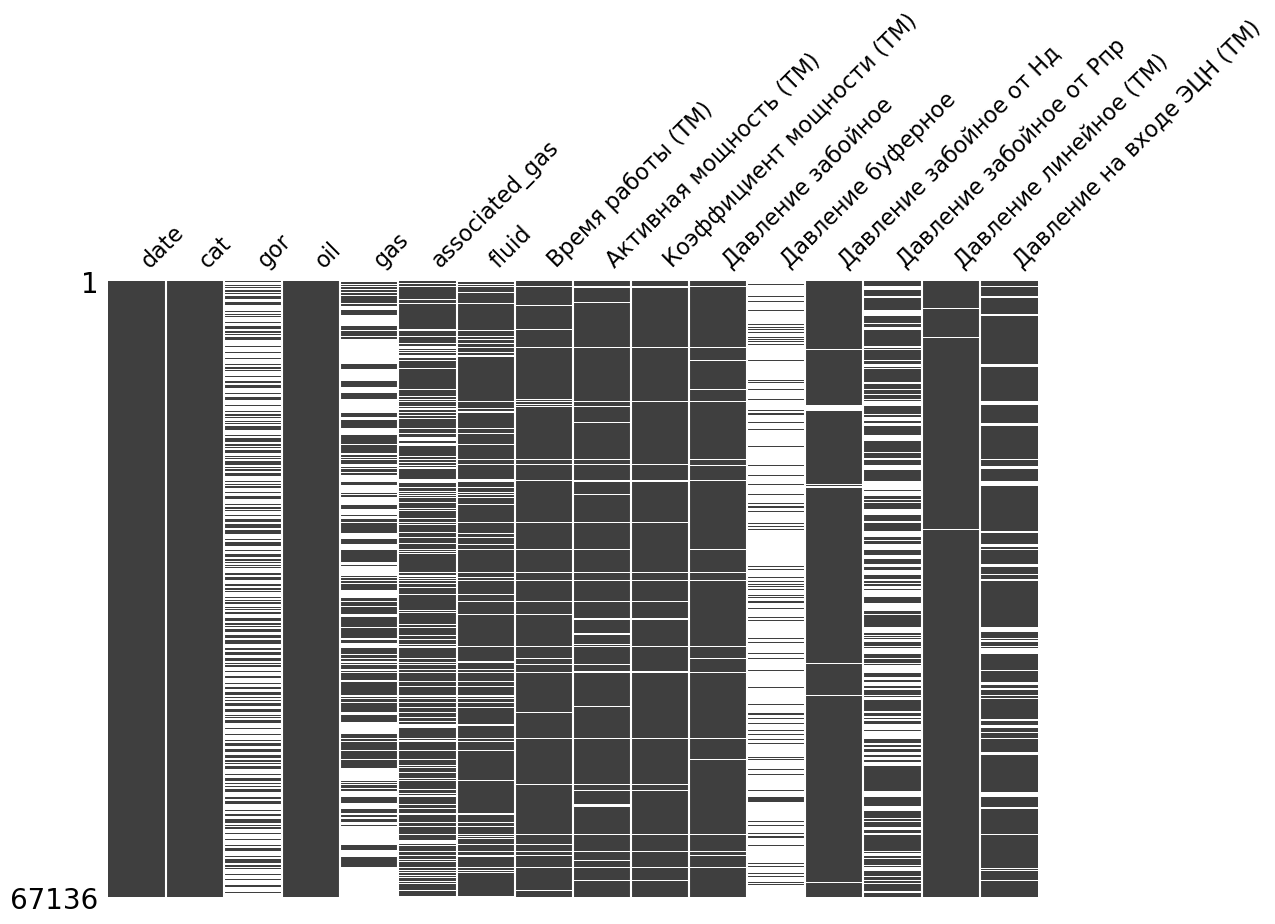

In [8]:
matrix(df, sparkline=False, figsize=(12,8))